# Evaluation Notebook

#### Imports

In [126]:
import os
from pathlib import Path
import numpy as np
import torch
import torch.nn as nn
import types
import sys
from tqdm import tqdm
import matplotlib.pyplot as plt

import gymnasium as gym
from gymnasium.wrappers import RecordEpisodeStatistics
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3 import PPO
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor

import minihack

#### Parameters

In [ ]:
ENV_ID = "MiniHack-Room-Ultimate-15x15-v0"
MODEL = "PPO_RND"
MODEL_PATH = f"./data/models/{MODEL}/best_hp_model"
VIDEOS_DIR = f"./data/videos/{MODEL}"
N_EPISODES = 5
FPS = 1
SEED = 42
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
KEYS_FOR_POLICY = ("glyphs_crop", "blstats")

#### Custom feature extractor (direct copy from base code)

In [9]:
class MiniHackCNN(BaseFeaturesExtractor):
    def __init__(self, observation_space, features_dim=256):
        super().__init__(observation_space, features_dim)
        glyphs = observation_space.spaces["glyphs_crop"]
        n_glyphs = int(glyphs.high.max()) + 1
        H, W = glyphs.shape
        self.embed = nn.Embedding(n_glyphs, 32)
        self.conv = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Flatten(),
        )
        self._conv_out = 64 * H * W
        bl_dim = observation_space.spaces["blstats"].shape[0]
        self.fc = nn.Sequential(
            nn.Linear(self._conv_out + bl_dim, features_dim),
            nn.ReLU(),
        )

    def forward(self, obs):
        x = self.embed(obs["glyphs_crop"].long()).permute(0, 3, 1, 2)
        x = self.conv(x)
        x = torch.cat([x, obs["blstats"].float()], dim=1)
        return self.fc(x)
    
# Register feature module
features_mod = types.ModuleType("features")
features_mod.MiniHackCNN = MiniHackCNN
sys.modules["features"] = features_mod

#### Environment setup

In [10]:
def make_eval_env(seed):
    def thunk():
        env = gym.make(
            ENV_ID,
            observation_keys=("glyphs_crop", "blstats", "pixel", "message", "chars"),
            render_mode=None,
        )
        env = RecordEpisodeStatistics(env)
        env.reset(seed=seed)
        return env
    return thunk

## Video recording

In [57]:
def record_video(model_path, out_dir=VIDEOS_DIR, n_episodes=N_EPISODES, fps=FPS):
    os.makedirs(out_dir, exist_ok=True)
    env = DummyVecEnv([make_eval_env(SEED)])
    model = PPO.load(model_path, device=DEVICE, custom_objects={
        "clip_range": lambda _: 0.2,
        "lr_schedule": lambda _: 3e-4,
        "MiniHackCNN": MiniHackCNN,
    })
    for ep in range(n_episodes):
        frames, done, ep_ret = [], False, 0.0
        obs = env.reset()
        while not done:
            frames.append(obs["pixel"][0])
            action, _ = model.predict(
                {k: obs[k] for k in KEYS_FOR_POLICY}, deterministic=True
            )
            obs, rewards, dones, _ = env.step(action)            
            done = bool(dones[0])
            ep_ret += rewards[0]

        out_path = Path(out_dir) / f"episode_{ep:03d}.mp4"
        import imageio.v3 as iio
        iio.imwrite(out_path, np.stack(frames), fps=fps)
        print(f"Saved video: {out_path}")

In [49]:
record_video(MODEL_PATH, out_dir=VIDEOS_DIR, n_episodes=1, fps=1)

[[32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32]
 [32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32]
 [32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32]
 [32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32]
 [32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32]
 [32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32]
 [32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32]
 [32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32]
 [32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32]
 [32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32]
 [32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32]
 [32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32]
 [32 46 46 32 32 32 32 32 32 32 32 32 32 32 32 32 32]
 [32 60 46 46 32 32 32 32 32 32 32 32 32 32 32 32 32]
 [32 46 64 46 32 32 32 32 32 32 32 32 32 32 32 32 32]
 [32 46 46 46 32 32 32 32 32 32 32 32 32 32 32 32 32]
 [32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32]]
[[32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32]
 [32 32 32 32 32 32 32 32 3

## Heatmap visualization

In [80]:
def collect_heatmap(n_runs=50):
    env = DummyVecEnv([make_eval_env(SEED)])
    model = PPO.load(MODEL_PATH, device=DEVICE, custom_objects={"MiniHackCNN": MiniHackCNN})
    obs = env.reset()
    H, W = obs["pixel"][0].shape[:2]
    H //= 16; W //= 16
    heat = np.zeros((H, W), int)
    char_map = obs["chars"][0]
    for _ in range(n_runs):
        obs = env.reset()
        entrance = tuple(map(int, obs["blstats"][0][:2]))
        done, steps = False, 0
        while not done and steps <= 128:
            x, y = map(int, obs["blstats"][0][:2])
            heat[y, x] += 1
            action, _ = model.predict(
                {k: obs[k] for k in KEYS_FOR_POLICY}, deterministic=True
            )
            char_map = obs["chars"][0]
            obs, _, dones, _ = env.step(action)
            done = bool(dones[0]) 
            steps += 1
    return entrance, heat, char_map

def show_heatmap(heat, entrance=None, exit=None, teleporters=None, monsters=None, title="Heatmap"):
    plt.figure(figsize=(6,6))
    plt.imshow(heat, origin="lower", cmap="viridis", interpolation="nearest")
    plt.colorbar(label="visits")
    plt.title(title)

    if entrance:
        zx, zy = entrance
        plt.scatter(zx, zy, s=200, marker="o",
                    c="yellow", edgecolors="black",
                    linewidths=1, label="Entrance")

    if exit:
        ex, ey = exit
        plt.scatter(ex, ey, s=200, marker="X",
                    c="red", edgecolors="white",
                    linewidths=1, label="Exit")

    if teleporters:
        txs, tys = zip(*teleporters)
        plt.scatter(txs, tys, s=150, marker="D",
                    c="purple", edgecolors="white",
                    linewidths=1, label="Teleporter")
        
    if monsters:
            mxs, mys = zip(*monsters)
            plt.scatter(mxs, mys, s=150, marker="s",
                        c="green", edgecolors="white",
                        linewidths=1, label="Monster")

    if entrance or exit or teleporters:
        plt.legend(loc="upper right")

    plt.tight_layout()
    plt.show()


In [ ]:
entrance, heat, char_map = collect_heatmap(n_runs=1)

heat_capped = np.minimum(heat, 10)

ymin, ymax = 3, 17
xmin, xmax = 32, 46

crop_y0 = ymin - 0
crop_x0 = xmin - 0

ent_x, ent_y = entrance
ent_x_cropped = ent_x - crop_x0
ent_y_cropped = ent_y - crop_y0

crop = heat_capped[crop_y0 : ymax+2, crop_x0 : xmax+2]

char_crop = char_map[crop_y0 : ymax+2, crop_x0 : xmax+2]

ys, xs = np.where(char_crop == 62)
exit_pos = (int(xs[0]), int(ys[0])) if xs.size else None

t_ys, t_xs = np.where(char_crop == 94)
teleporter_positions = list(zip(t_xs.tolist(), t_ys.tolist()))

m_ys, m_xs = np.where((char_crop == 100) | (char_crop == 114))
monster_positions = list(zip(m_xs.tolist(), m_ys.tolist()))

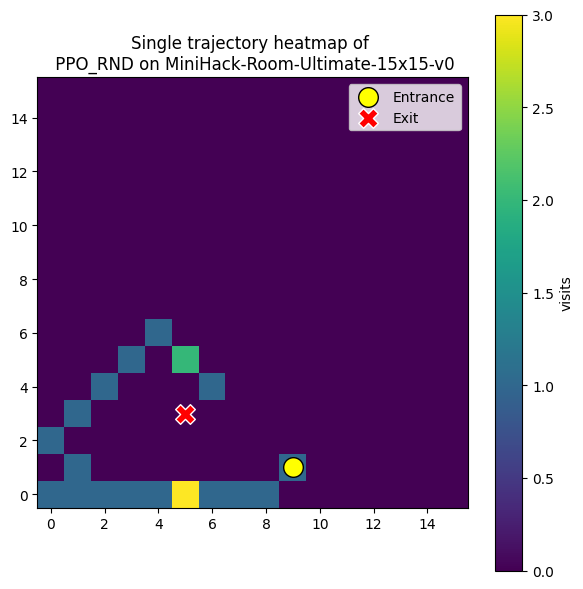

In [130]:
show_heatmap(
    crop,
    entrance=(ent_x_cropped, ent_y_cropped),
    exit=exit_pos,
    teleporters=teleporter_positions,
    monsters=monster_positions,
    title=f"Single trajectory heatmap of \n {MODEL} on {ENV_ID}"
)

## Agent metric evaluation

In [123]:
def evaluate_agent_metrics(model_path,
                           n_runs=100,
                           seed=SEED,
                           device=DEVICE):
    env = DummyVecEnv([make_eval_env(seed)])
    model = PPO.load(
        model_path,
        device=device,
        custom_objects={"MiniHackCNN": MiniHackCNN}
    )

    times = []
    success_count = 0
    monster_deaths = 0
    timeout_count = 0
    unique_positions_counts = []     # per run
    monster_sighting_steps = []      # number of steps with at least one monster in view
    teleporter_sighting_steps = []   # number of steps with at least one teleporter in view
    first_monster_step_runs = []     # step index of first monster sighting (or None)
    first_teleporter_step_runs = []  # step index of first teleporter sighting (or None)

    for run in tqdm(range(n_runs), desc="Evaluating runs"):
        obs = env.reset()
        done, step = False, 0

        # per‐run trackers
        visited = set()
        monster_steps = 0
        tele_steps = 0
        first_monster_step = None
        first_tele_step = None

        # get the global entrance position once
        bl0 = obs["blstats"][0]
        ent_y, ent_x = int(bl0[0]), int(bl0[1])
        while not done:
            # current global position
            bl = obs["blstats"][0]
            y, x = int(bl[0]), int(bl[1])            
            visited.add((x, y))

            char_map = obs["chars"][0]

            if np.any((char_map == 114) | (char_map == 100)):
                monster_steps += 1
                if first_monster_step is None:
                    first_monster_step = step

            if np.any(char_map == 94):
                tele_steps += 1
                if first_tele_step is None:
                    first_tele_step = step

            # step the agent
            action, _ = model.predict(
                {k: obs[k] for k in KEYS_FOR_POLICY}, deterministic=True
            )
            obs, reward, dones, infos = env.step(action)
            done = bool(dones[0])
            step += 1

        info = infos[0]
        if info.get("TimeLimit.truncated", False):
            timeout_count += 1
        elif reward[0] > 0:
            success_count += 1
            times.append(step)
        else:
            monster_deaths += 1

        unique_positions_counts.append(len(visited))
        monster_sighting_steps.append(monster_steps)
        teleporter_sighting_steps.append(tele_steps)
        first_monster_step_runs.append(first_monster_step)
        first_teleporter_step_runs.append(first_tele_step)

    avg_time = np.mean(times) if times else None
    success_rate = success_count / n_runs
    monster_death_rate = monster_deaths / n_runs
    timeout_rate = timeout_count / n_runs

    avg_unique_cells = np.mean(unique_positions_counts)
    avg_monster_steps = np.mean(monster_sighting_steps)
    avg_tele_steps = np.mean(teleporter_sighting_steps)
    frac_runs_saw_monster = sum(1 for s in monster_sighting_steps if s>0) / n_runs
    frac_runs_saw_tele = sum(1 for s in teleporter_sighting_steps if s>0) / n_runs
    avg_first_monster = np.nanmean([
        s if s is not None else np.nan for s in first_monster_step_runs
    ])
    avg_first_tele = np.nanmean([
        s if s is not None else np.nan for s in first_teleporter_step_runs
    ])

    return {
        "average_time":       avg_time,
        "success_rate":       success_rate,
        "monster_death_rate": monster_death_rate,
        "timeout_rate":       timeout_rate,
        "avg_unique_cells_visited":      avg_unique_cells,
        "avg_steps_with_monsters_in_view":   avg_monster_steps,
        "avg_steps_with_teleporters_in_view": avg_tele_steps,
        "frac_runs_saw_monster":         frac_runs_saw_monster,
        "frac_runs_saw_teleporter":      frac_runs_saw_tele,
        "avg_step_of_first_monster_sighting":   avg_first_monster,
        "avg_step_of_first_teleporter_sighting": avg_first_tele,
    }


In [124]:
def print_metrics_overview(metrics: dict, name: str = None):
    """
    Print all metrics with perfectly uniform alignment.
    """
    # Header
    header = f"Metrics Overview: {name}" if name else "Metrics Overview"
    sep = "-" * len(header)
    print(header)
    print(sep)

    # Core metrics
    print(f"{'Success Rate':30}: {metrics['success_rate']*100:6.2f}%")
    avg_time = metrics['average_time']
    avg_time_str = f"{avg_time:.1f}" if avg_time is not None else "—"
    print(f"{'Average Steps to Success':30}: {avg_time_str:>6}")
    print(f"{'Monster Death Rate':30}: {metrics['monster_death_rate']*100:6.2f}%")
    print(f"{'Timeout Rate':30}: {metrics['timeout_rate']*100:6.2f}%")

    print()

    # Exploration & Sightings
    print("Exploration & Sightings")
    print(f"{'Avg. Unique Cells Visited':30}: {metrics['avg_unique_cells_visited']:6.1f}")
    print(f"{'Avg. Steps Seeing Monsters':30}: {metrics['avg_steps_with_monsters_in_view']:6.1f}")
    print(f"{'Avg. Steps Seeing Teleporters':30}: {metrics['avg_steps_with_teleporters_in_view']:6.1f}")
    print(f"{'Runs That Saw ≥1 Monster':30}: {metrics['frac_runs_saw_monster']*100:6.2f}%")
    print(f"{'Runs That Saw ≥1 Teleporter':30}: {metrics['frac_runs_saw_teleporter']*100:6.2f}%")
    print(f"{'Avg. Step of 1st Monster Sighting':30}: {metrics['avg_step_of_first_monster_sighting']:^6}")
    print(f"{'Avg. Step of 1st Teleporter Sighting':30}: {metrics['avg_step_of_first_teleporter_sighting']:^6}")

    print(sep)


In [127]:
stats = evaluate_agent_metrics(MODEL_PATH, n_runs=100)
print_metrics_overview(stats, name=f"{MODEL} on {ENV_ID}")


Evaluating runs: 100%|██████████| 100/100 [01:56<00:00,  1.16s/it]

Metrics Overview: PPO_RND on MiniHack-Room-Ultimate-15x15-v0
------------------------------------------------------------
Success Rate                  :  65.00%
Average Steps to Success      :   55.8
Monster Death Rate            :  35.00%
Timeout Rate                  :   0.00%

Exploration & Sightings
Avg. Unique Cells Visited     :   31.8
Avg. Steps Seeing Monsters    :    2.3
Avg. Steps Seeing Teleporters :   79.4
Runs That Saw ≥1 Monster      :  59.00%
Runs That Saw ≥1 Teleporter   :  75.00%
Avg. Step of 1st Monster Sighting: 5.677966101694915
Avg. Step of 1st Teleporter Sighting: 17.786666666666665
------------------------------------------------------------
